# Section 3: Unsupervised learning – Clustering
In this unsupervised learning task, the objective is to cluster Reddit comments based on the words used
within them. The aim is to identify patterns and group comments with similar words together. 
Note: Use only the column body (i.e. the textual data) to extract the features used in this section, do not
feed “author”, “subreddit” and “created_utc” to the model.


In [1]:
# all required imports
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
%pip install wordcloud
%pip install rep
import re
from wordcloud import WordCloud

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Data Loading and brief Exploration

In [2]:
# load clean unsupervised dataset
df_unsup = pd.read_csv("../data/clean_unsupervised.csv")

# thee clean_unuspervised dataset is derived from section 1 and it is the 
# dataset with the column 'body_clean' with lemmatization and stop-words cutting

# look number of comments
print(f"{df_unsup.head(10)}")


               author        subreddit   created_utc  \
0       ejchristian86  TwoXChromosomes  1.388534e+09   
1           ZenDragon           gaming  1.388534e+09   
2        savoytruffle        AskReddit  1.388534e+09   
3        hentercenter     stlouisblues  1.388534e+09   
4        rick-o-suave             army  1.388534e+09   
5        olivermihoff    AdviceAnimals  1.388534e+09   
6           Cleriesse        AskReddit  1.388534e+09   
7   murderer_of_death    MorbidReality  1.388534e+09   
8          SpiralSoul   Pathfinder_RPG  1.388534e+09   
9  IRideVelociraptors       FreeEBOOKS  1.388534e+09   

                                                body  \
0  I hadn't ever heard of them before joining thi...   
1                At 7680 by 4320 with 64x AA, right?   
2                                            bite me   
3                    Damn that was a good penalty :(   
4  I swore into DEP on 6-OCT and I left 5-NOV und...   
5  Not that it's ever to be equated because it'

In [3]:
# informations about the shape of the dataset and also the description
print(f"{df_unsup.shape}")
print(f"{df_unsup['body_clean'].str.len().describe()}")

# it calculates the length of chars of the comments in the section 'body_clean'
# the avg len of the comments is 80 char, the smallest is one char and the longest is 10k chars

(1107946, 6)
count    1.092674e+06
mean     8.088918e+01
std      1.415220e+02
min      1.000000e+00
25%      2.300000e+01
50%      5.700000e+01
75%      7.500000e+01
max      1.079900e+04
Name: body_clean, dtype: float64


In [4]:
num_subreddits = df_unsup['subreddit'].nunique()
print(f"Number of subreddits: {num_subreddits}")

Number of subreddits: 3970


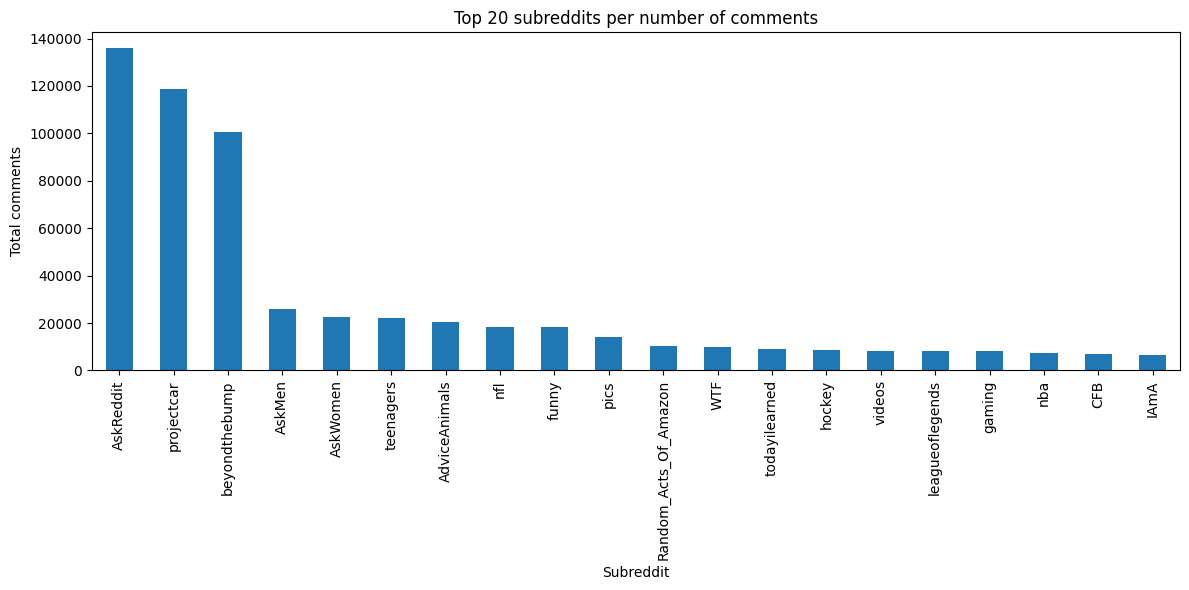

In [5]:
plt.figure(figsize=(12,6))
df_unsup['subreddit'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 subreddits per number of comments")
plt.xlabel("Subreddit")
plt.ylabel("Total comments")
plt.tight_layout()
plt.show()


In [7]:
# first drop empty words
df_unsup = df_unsup.dropna(subset=['body_clean'])
# second convert to string 
df_unsup['body_clean'] = df_unsup['body_clean'].astype(str)
# third remove empty or whitespaces
df_unsup = df_unsup[df_unsup['body_clean'].str.strip() != ""]
# last, removing comments under 2 chars length
df_unsup = df_unsup[df_unsup['body_clean'].str.strip().str.len() >= 2]


print(f"dimension after cleaning: {len(df_unsup)}")

# removing 16213 lines

dimension after cleaning: 1091733


In [8]:
# to avoid dominance of highly active subreddits, we sample at most N comments per subreddit

max_per_subreddit = 5000  # each subreddit maximum contribute with 5000 comments 

df_sample = (
    df_unsup
      .groupby("subreddit", group_keys=False) # group dataframe with the column subreddit
      .apply(lambda x: x.sample( # for each group apply the following function
          n=min(len(x), max_per_subreddit), # choose how many comments to sample for each comments
          random_state=42
      ))
)

print(f"Sampling dataframe length: {len(df_sample)}")
print(f"{df_sample["subreddit"].value_counts().head(5)}")
print(f"{df_sample["subreddit"].value_counts().tail(5)}")

# we start from over a million comment reducting the size of total comments in 616144



Sampling dataframe length: 616144
subreddit
worldnews        5000
AdviceAnimals    5000
beyondthebump    5000
WTF              5000
hockey           5000
Name: count, dtype: int64
subreddit
saab        1
weddings    1
GaState     1
bubbling    1
ccna        1
Name: count, dtype: int64


C:\Users\bonio\AppData\Local\Temp\ipykernel_4644\3123726097.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample( # for each group apply the following function


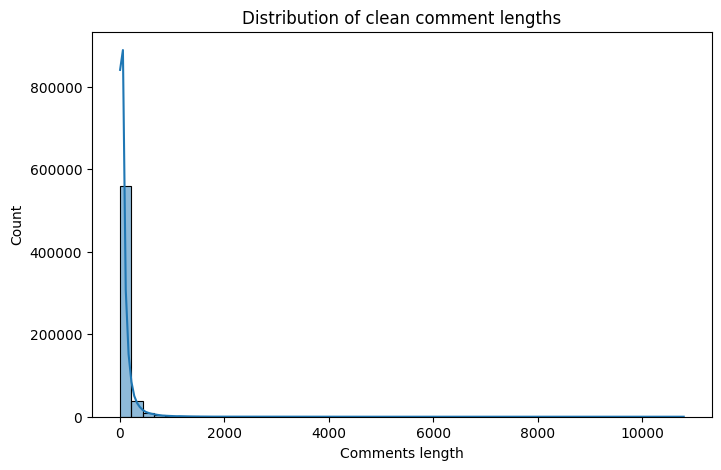

In [9]:
# distribution of the lengths of the comments

plt.figure(figsize=(8,5))
sns.histplot(df_sample['body_clean'].str.len(), bins=50, kde=True) # show kde
plt.title("Distribution of clean comment lengths")
plt.xlabel("Comments length")
plt.ylabel("Count")
plt.show()

# we need a better visualization

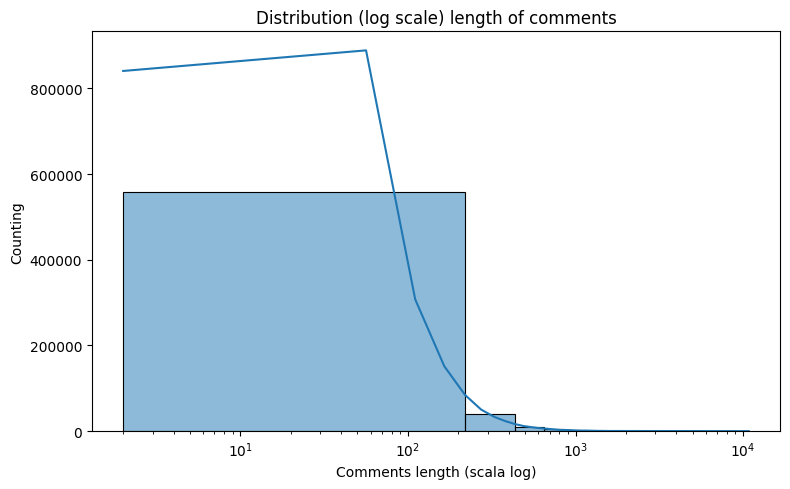

In [10]:
# log scaled on axes x
plt.figure(figsize=(8,5))
sns.histplot(df_sample['body_clean'].str.len(), bins=50, kde=True)
plt.xscale('log')
plt.title("Distribution (log scale) length of comments")
plt.xlabel("Comments length (scala log)")
plt.ylabel("Counting")
plt.tight_layout()
plt.show()

# the majority of the coments is between 10 and 100 characters but we have a long tail
# rare comments with 10000 characters

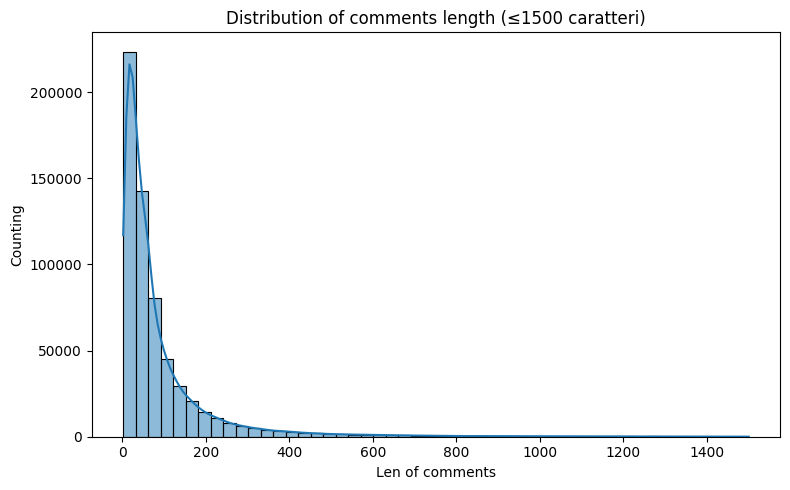

In [11]:
filtered = df_sample[df_sample['body_clean'].str.len() <= 1500]

plt.figure(figsize=(8,5))
sns.histplot(filtered['body_clean'].str.len(), bins=50, kde=True)
plt.title("Distribution of comments length (≤1500 caratteri)")
plt.xlabel("Len of comments")
plt.ylabel("Counting")
plt.tight_layout()
plt.show()

# we notice a peak among 20 and 100 comments, so most of them are short.

## Dimensionality reduction
Text data is transformed using TF-IDF, reduced with TruncatedSVD, and clustered using KMeans.  
We removed the custom `token_pattern` to align the TF-IDF configuration
with Section 1, relying on the default scikit-learn tokenization.
This also avoids unintentionally filtering out tokens such as emojis.

In [12]:
# TF-IDF vectorizer applied on the body_clean
tfidf = TfidfVectorizer(
    max_features=10000,
    min_df=10,    # because under 10 characters we have rare comment              
    max_df=0.4,   # common words         
    stop_words='english', 
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b",
    ngram_range=(1, 2)
)

X = tfidf.fit_transform(df_sample['body_clean'])
print(f"TF-IDF dimension: {X.shape}")

TF-IDF dimension: (616144, 10000)


In [13]:
# dimensionality reduction with Truncated SVD
# n_comp = size/(30-60) --> we select a number of features between 200-300
n_components = 300
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced = svd.fit_transform(X)
print(f"Reduced feature shape: {X_reduced.shape}")

Reduced feature shape: (616144, 300)


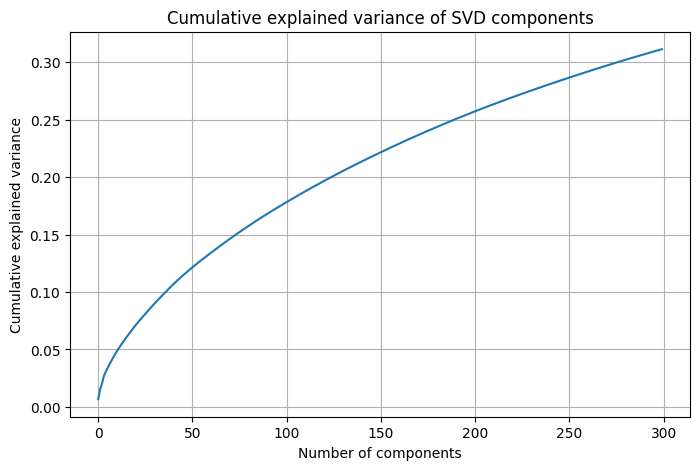

In [14]:
explained = svd.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8,5))
plt.plot(explained)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance of SVD components")
plt.grid(True)
plt.show()


### Short comment about TF-IDF, Truncated SVD and Explained Cumulative variance
To convert textual data into numerical representation suitable for ML, a TF-IDF vectorizer was applied. We have a sparse matrix of shape (616144 x 10000). Since TF-IDF produces a very high dimensional representation, Truncated-SVD was applied to reduce dimensionality and preserving the main semantic structure. 
The cumulative explained variance grows steadily but slowly, and at 200 components arount 25% is retained, with 300 components we reach approximately 33%.


### Utilities stuff to demonstrate the validity of the TF-IDF and of the Truncated SVD

C:\Users\bonio\AppData\Local\Temp\ipykernel_4644\2313872781.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top20, x="mean_tfidf", y="term", palette="viridis")


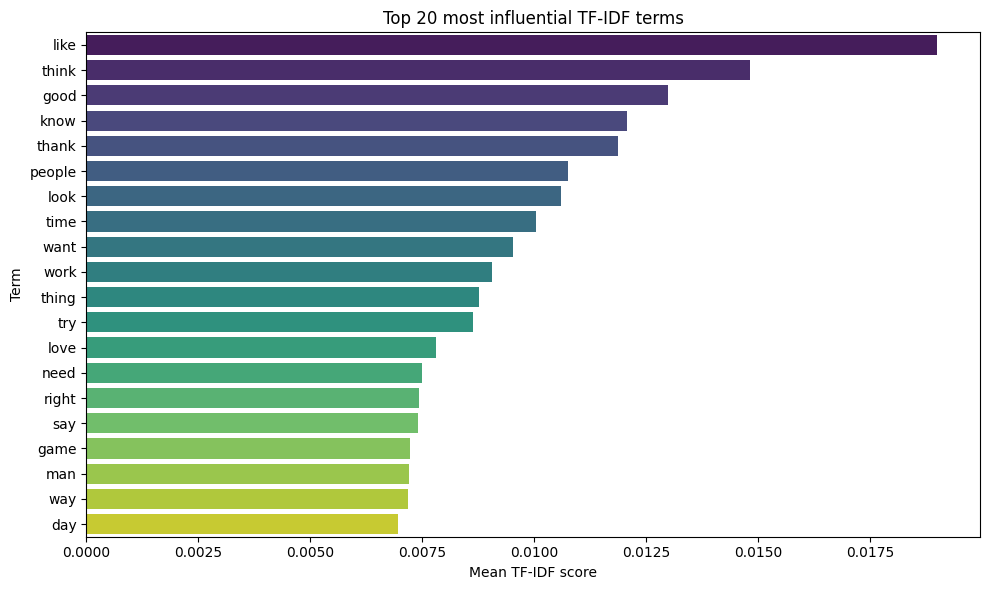

In [15]:
# get feature names and compute mean TF-IDF score per term
feature_names = tfidf.get_feature_names_out()
tfidf_means = np.asarray(X.mean(axis=0)).ravel()

# create the dataframe
tfidf_df = pd.DataFrame({
    "term": feature_names,
    "mean_tfidf": tfidf_means
})

# Sort and take top 20
top20 = tfidf_df.sort_values(by="mean_tfidf", ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=top20, x="mean_tfidf", y="term", palette="viridis")
plt.title("Top 20 most influential TF-IDF terms")
plt.xlabel("Mean TF-IDF score")
plt.ylabel("Term")
plt.tight_layout()
plt.show()

### Top 20 Most Influential TF-IDF Terms
The top 20 terms were then visualized in a horizontal bar chart.
This analysis highlights the most semantically dominant words in the dataset, including conversational verbs (*like*, *think*, *know*) and emotionally charged expressions (*thank*, *love*, *need*). The presence of generic terms (*thing*, *time*, *day*) is expected in large-scale social discourse, while topic-specific words (*game*, *work*) suggest underlying thematic clusters.

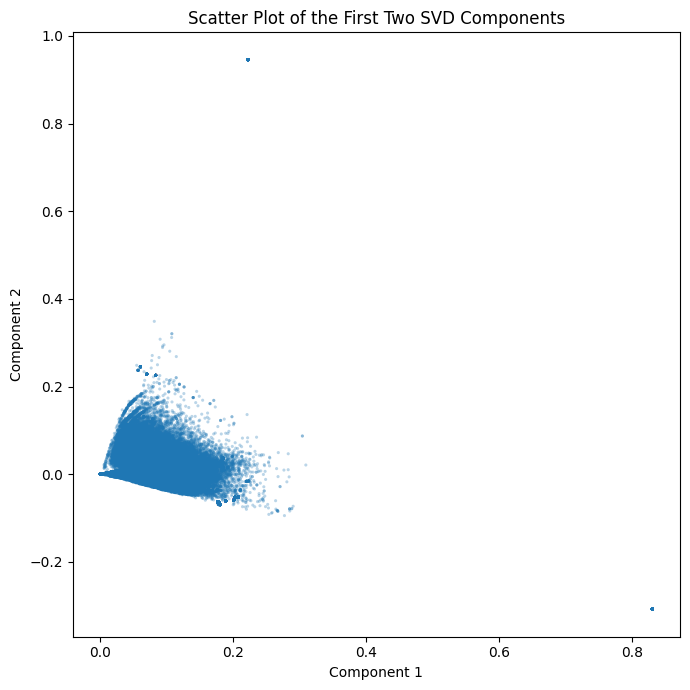

In [16]:
# Scatter plot of the first two SVD components
plt.figure(figsize=(7,7))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    s=5,
    alpha=0.3,
    edgecolors='none'
)
plt.title("Scatter Plot of the First Two SVD Components")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

### Scatter Plot of the First Two SVD Components
To explore the geometric structure of the dataset prior to clustering, we visualized the projection of all documents onto the first two components of the Truncated SVD space. Each point represents a document in the reduced semantic space.
Although these two components capture only a fraction of the total variance, the plot reveals a dense central region and several outliers. This suggests that most documents share similar semantic profiles, while a minority exhibit distinct patterns.

## Clustering with K-Means  
Silhouette is the method used to measure how much a point is near and far by its cluster. If the values are like 1 -> cluster ben distinguished, if values tend to -> 0 the clusters are overlapped. The number of clusters was selected using silhouette analysis, as it provides a quantitative measure of cluster separation.

In [17]:
# use of AI to avoid long computation

sil_scores = []

for k in range(2, 15):
    # aggiunto da adri, problemi
    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048)
    labels_tmp = km.fit_predict(X_reduced)

    score = silhouette_score(
        X_reduced,
        labels_tmp,
        sample_size=10000,
        random_state=42
    )

    sil_scores.append(score)
    print(f"k={k}, silhouette={score:.3f}")


k=2, silhouette=0.026
k=3, silhouette=0.222
k=4, silhouette=0.200
k=5, silhouette=0.012
k=6, silhouette=0.021
k=7, silhouette=0.017
k=8, silhouette=0.029
k=9, silhouette=0.046
k=10, silhouette=0.022
k=11, silhouette=0.017
k=12, silhouette=0.063
k=13, silhouette=0.030
k=14, silhouette=0.025


Based on the silhouette analysis, the optimal number of clusters was selected as *k = 3*, since this value achieved the highest silhouette score and provided the best balance between cluster separation and internal cohesion. After determining the optimal value of *k*, a K-Means model was fitted on the SVD-reduced feature space using `n_init=10` to ensure stable centroid initialization.
The resulting cluster labels were then attached to the sampled dataframe to facilitate inspection and downstream analysis.


In [19]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_reduced)
# attach cluster labels to the dataframe to better visualize it
df_sample = df_sample.reset_index(drop=True)
df_sample["cluster_kmeans"] = labels_km

print(f"{df_sample.head(10)}")

       author subreddit   created_utc  \
0     DCDVath      1022  1.390343e+09   
1  razor_edge      1022  1.390578e+09   
2  razor_edge      1022  1.389429e+09   
3  razor_edge      1022  1.390617e+09   
4  razor_edge      1022  1.390536e+09   
5     DCDVath      1022  1.390343e+09   
6  razor_edge      1022  1.390538e+09   
7     DCDVath      1022  1.389629e+09   
8  TrapperJon      1022  1.390964e+09   
9   Betrivent      1022  1.389831e+09   

                                                body  \
0  I just picked one up myself at the gun show 2 ...   
1                               No problems at all.    
2  The receiver is the only component classified ...   
3  Eley Tenex and RWS R-50 were the best of the t...   
4  A conclusive deduction in an opinion? Wtf are ...   
5  It will come back around one of these days. Ev...   
6  [Here is my Ultra Light 10/22 build](http://im...   
7  I would gladly pay a nickel a round. Just boug...   
8  We are now due to the stupid SAFE Act... 

In [20]:
print(labels_km)

[1 1 1 ... 1 2 1]


In [21]:
df_sample["cluster_kmeans"].value_counts().sort_index()

cluster_kmeans
0      5000
1    550228
2     60916
Name: count, dtype: int64

##### Cluster Size Distribution

After fitting the final K-Means model with *k = 3*, we examined the distribution of documents across the three clusters. The results show a highly unbalanced structure, with one dominant cluster and two significantly smaller ones:
- **Cluster 0:** 5,000 documents  
- **Cluster 1:** 550,228 documents  
- **Cluster 2:** 60,916 documents  
This imbalance is expected in large-scale text datasets, where most documents share a common conversational style and therefore fall into a broad, general-purpose cluster. The smaller clusters typically capture more specific linguistic patterns, niche topics, or distinctive semantic structures.

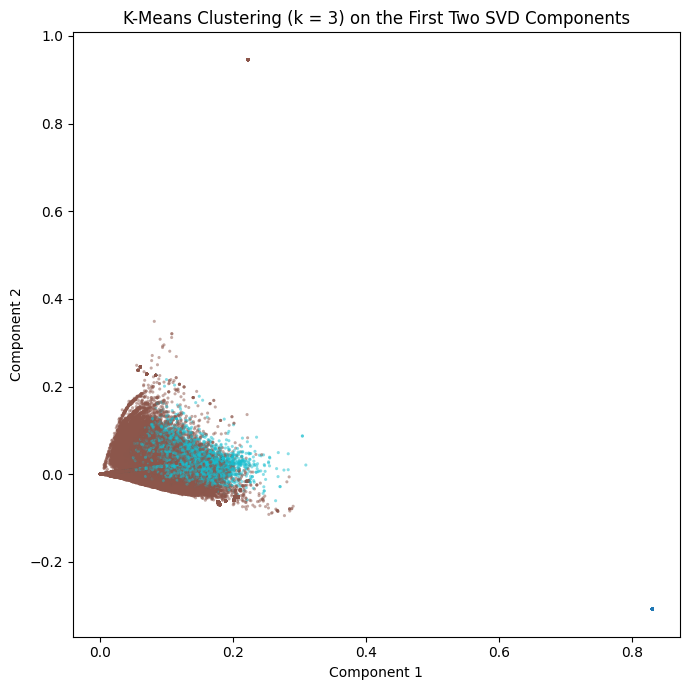

In [22]:
# Scatter plot of the first two SVD components colored by K-Means clusters
plt.figure(figsize=(7,7))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=labels_km,
    cmap="tab10",
    s=5,
    alpha=0.5,
    edgecolors='none'
)
plt.title("K-Means Clustering (k = 3) on the First Two SVD Components")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

some clusters are well separed , when others are overlapped be cause the SVD compnents catch only a small portion of the variance and also there is a dominant cluster.

k=3, inertia=186033.29
k=4, inertia=185491.50
k=5, inertia=184650.95
k=6, inertia=180952.52
k=7, inertia=180815.44
k=8, inertia=177463.43
k=9, inertia=176333.20
k=10, inertia=176315.56
k=11, inertia=174912.37
k=12, inertia=165960.92
k=13, inertia=173662.99
k=14, inertia=173619.07
k=15, inertia=171776.95


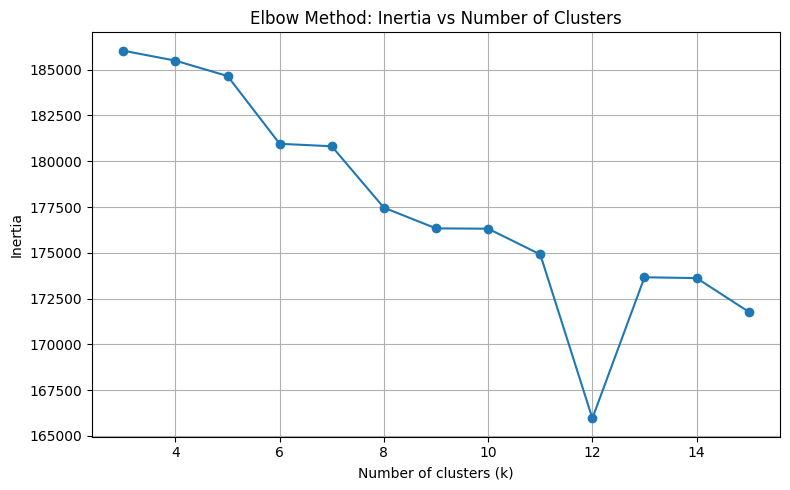

(range(3, 16),
 [186033.29028631034,
  185491.5044902673,
  184650.94659242552,
  180952.52314526454,
  180815.43981538096,
  177463.43151596613,
  176333.19767254984,
  176315.56134270722,
  174912.36550543644,
  165960.9247524361,
  173662.99094843163,
  173619.0695883099,
  171776.9538444881])

In [23]:
def elbow_method(
    X,
    k_min=2,
    k_max=15,
    batch_size=2048,
    random_state=42
):
    """Compute and plot inertia values for MiniBatchKMeans across a range of k."""

    inertias = []
    ks = range(k_min, k_max + 1)

    for k in ks:
        km = MiniBatchKMeans(
            n_clusters=k,
            batch_size=batch_size,
            random_state=random_state,
            init="k-means++",
            n_init="auto"
        )
        km.fit(X)
        inertia = km.inertia_
        inertias.append(inertia)

        print(f"k={k}, inertia={inertia:.2f}")

    # Plot inertia curve
    plt.figure(figsize=(8, 5))
    plt.plot(ks, inertias, marker='o')
    plt.title("Elbow Method: Inertia vs Number of Clusters")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return ks, inertias


# Example usage
elbow_method(X_reduced, k_min=3, k_max=15)

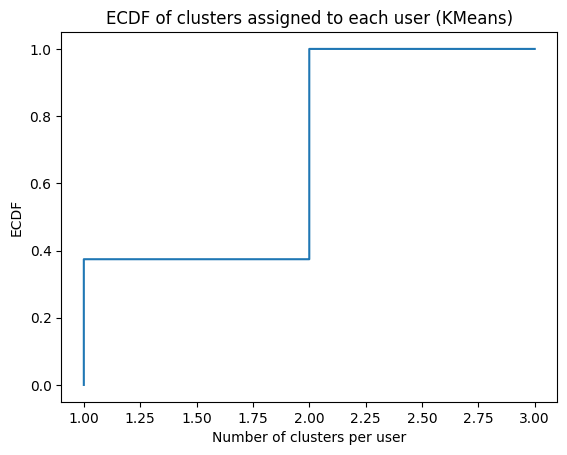

In [24]:
# user distribution analysis - ECDF
# each user can be assigned to multiple cluster because we cluster comments
# number of distinct clusters per user
user_cluster_count = (
    df_sample.groupby("author")["cluster_kmeans"]
    .nunique()
)

# ECDF
x = np.sort(user_cluster_count.values)
y = np.arange(1, len(x) + 1) / len(x)

plt.step(x, y)
plt.xlabel("Number of clusters per user")
plt.ylabel("ECDF")
plt.title("ECDF of clusters assigned to each user (KMeans)")
plt.show()


#### ECDF of Cluster Assignments per User
The ECDF shows that approximately 40% of users have comments assigned to only one cluster, while nearly all users (100%) are associated with two or fewer clusters. This indicates that most users exhibit semantically consistent behavior, contributing to a narrow range of topics or linguistic styles. The presence of users spanning multiple clusters suggests some degree of thematic diversity, but overall the clustering model captures coherent user-level patterns.
This analysis reinforces the interpretability of the clustering results and provides a user-centric validation of the semantic structure discovered.

In [25]:
print(f"cluster per user: {user_cluster_count.mean():.2f}")
print(f"std : {user_cluster_count.std():.2f}")

cluster per user: 1.63
std : 0.48


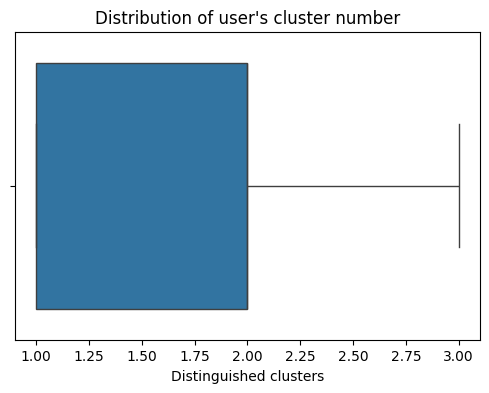

In [26]:
# boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x=user_cluster_count)
plt.title("Distribution of user's cluster number")
plt.xlabel("Distinguished clusters")
plt.show()

In [29]:
#cluster interpretation – Top terms
k = 3
terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(k):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top_terms)}")

Cluster 0: aa, aaron, accelerate, ab, acceptance, accept, able help, abide, acceleration, abstract
Cluster 1: aap, aa, aaa, able play, accidentally, able, able use, abortion, accounting, ability
Cluster 2: aap, ab, aa, aaa, able tell, abide, accountable, accidental, absolutely, acceptance


In [30]:
# cluster vs subreddit analysis
cluster_subreddit_dist = (
    pd.crosstab(
        df_sample["cluster_kmeans"],
        df_sample["subreddit"],
        normalize="index"
    )
)

cluster_subreddit_dist.head()


subreddit,1022,1200isplenty,1911,195,2007scape,2014goals,240sx,24hoursupport,2X_INTJ,30ROCK,...,yorku,youdontsurf,youngjustice,youtube,youtubehaiku,yugioh,zelda,zen,zombies,zyzz
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000044,0.000036,0.000029,0.000035,0.000173,0.000040,0.000045,0.000029,0.000004,0.000038,...,0.000009,0.000045,0.000007,0.000107,0.000236,0.000231,0.000320,0.000042,0.000044,0.000031
2,0.000000,0.000082,0.000016,0.000033,0.000066,0.000066,0.000016,0.000016,0.000016,0.000033,...,0.000000,0.000000,0.000033,0.000066,0.000213,0.000246,0.000263,0.000049,0.000049,0.000016


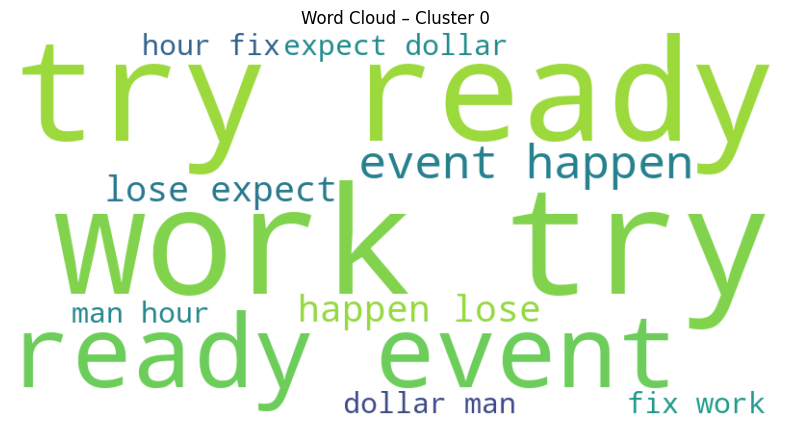

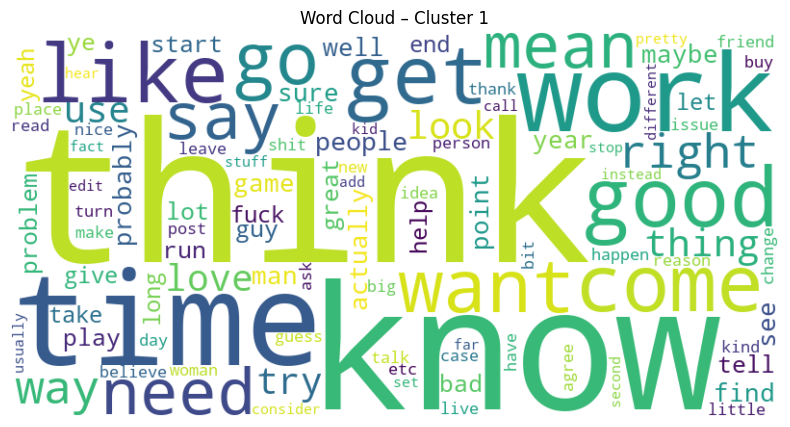

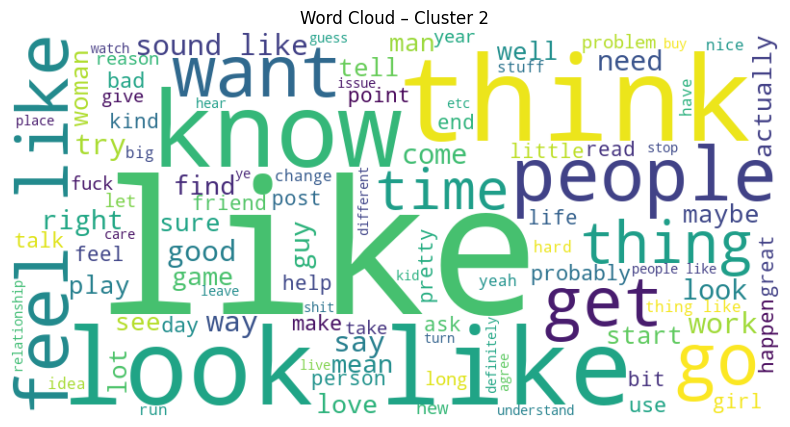

In [31]:
for i in range(k):
    cluster_comments = df_sample[df_sample["cluster_kmeans"] == i]["body_clean"]
    text = " ".join(cluster_comments)
    wc = WordCloud(width=800, height=400, max_words=100, background_color="white", stopwords="english").generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud – Cluster {i}")
    plt.show()

#### KMeans Cluster Interpretation (Word Clouds)

**Cluster 0 – Practical and action‑oriented language**  
The content reflects problem‑solving, planning, and everyday practical situations. Users in this cluster tend to discuss actions, logistics, and real‑life issues.

**Cluster 1 – Social, conversational, and general‑interest language**  
This cluster captures broad, interactive discussions typical of general‑interest subreddits. The tone is social and dialog‑based, covering entertainment, opinions, and casual conversation.

**Cluster 2 – Introspective and emotional language**  
Users in this cluster often express emotions, perceptions, and internal states. The content is more introspective, focusing on personal experiences and self‑reflection.

**Summary**  
The three clusters represent distinct communication styles:  
- Cluster 0 → pragmatic and action‑focused  
- Cluster 1 → social and conversational  
- Cluster 2 → introspective and emotional  

## Agglomerative Clustering

We apply Agglomerative Clustering on a smaller subset of the reduced TF-IDF features
to compare its behaviour with KMeans.


In [42]:
# use a smaller random subset for efficiency
sample_size = 20000  
df_small = df_sample.sample(n=sample_size, random_state=42)

# Match rows in X_reduced with df_small using the index
X_small = X_reduced[df_small.index.to_numpy(), :]

X_small.shape


(20000, 300)

In [43]:
ks_ag = range(2, 11)
sil_scores_ag = []

for k in ks_ag:
    agg = AgglomerativeClustering(n_clusters=k)
    labels_ag = agg.fit_predict(X_small)
    sil = silhouette_score(X_small, labels_ag)
    sil_scores_ag.append(sil)

ks_ag, sil_scores_ag


(range(2, 11),
 [0.36270396865410715,
  0.3702831625439146,
  0.36842998480106337,
  0.371401378787654,
  0.18655834813009486,
  0.1060760046787125,
  0.10815775639728153,
  0.10988560276196523,
  0.11126471867288365])

In [45]:
best_k_ag = ks_ag[int(np.argmax(sil_scores_ag))]
print(f"{best_k_ag}, {sil_scores_ag}")


5, [0.36270396865410715, 0.3702831625439146, 0.36842998480106337, 0.371401378787654, 0.18655834813009486, 0.1060760046787125, 0.10815775639728153, 0.10988560276196523, 0.11126471867288365]


In [46]:
agg_final = AgglomerativeClustering(n_clusters=best_k_ag)
labels_ag_final = agg_final.fit_predict(X_small)

df_small_ag = df_small.copy()
df_small_ag["cluster_ag"] = labels_ag_final

print(f"Count values: {df_small_ag["cluster_ag"].value_counts().sort_index()}")


Count values: cluster_ag
0    19534
1       51
2      150
3       89
4      176
Name: count, dtype: int64


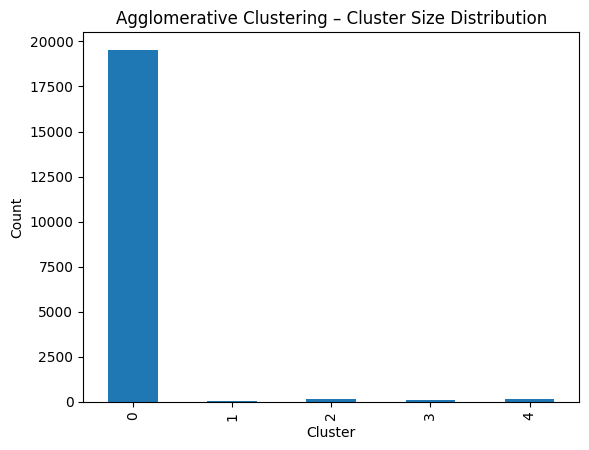

In [55]:
df_small_ag["cluster_ag"].value_counts().sort_index().plot(kind="bar")
plt.title("Agglomerative Clustering – Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

#### Cluster Size Distribution for Agglomerative Clustering (k = 5)
The agglomerative model produces a highly unbalanced partition: one dominant cluster containing the vast majority of documents (over 97%) and four very small clusters ranging from 51 to 176 documents. This pattern is typical of hierarchical clustering applied to high-dimensional text data, where the algorithm tends to isolate small, highly coherent semantic niches while grouping the remaining documents into a broad, dense cluster.

These micro-clusters often correspond to specific linguistic patterns, niche topics, or distinctive user behaviors. 

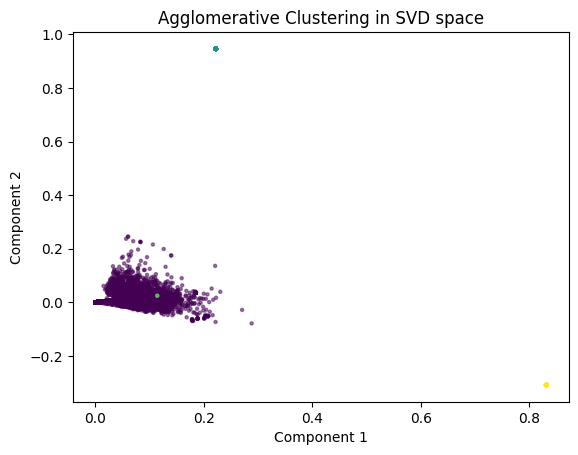

In [ ]:
plt.scatter(
    X_small[:, 0],
    X_small[:, 1],
    c=df_small_ag["cluster_ag"],
    s=5,
    alpha=0.5
)
plt.title("Agglomerative Clustering in SVD space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

# micro clusters 

In [ ]:
terms = tfidf.get_feature_names_out()

for k in sorted(df_small_ag["cluster_ag"].unique()):
    mask = df_small_ag["cluster_ag"] == k
    centroid = X_small[mask].mean(axis=0)
    centroid = np.asarray(centroid).ravel()
    # top 10 terms
    top_idx = centroid.argsort()[-10:][::-1]
    print(f"\nCluster {k} top terms:")
    print(", ".join(terms[top_idx]))


Cluster 0 top terms:
aap, aa, aaa, able play, accidentally, abortion, accounting, ability, absolutely love, abnormal

Cluster 1 top terms:
able use, able tell, abroad, ac, abort, academy, aap, account, absolutely right, access

Cluster 2 top terms:
aaa, aa, aaron, accomplish, ab, accompany, absurd, accommodate, accounting, able help

Cluster 3 top terms:
aaron, aap, aa, ab, aaa, abide, accelerate, acceptable, accurately, abstract

Cluster 4 top terms:
aa, aaron, accelerate, ab, acceptance, accept, able help, abide, acceleration, abstract


#### Top Terms – Agglomerative Clustering

The top-term analysis for the agglomerative clusters does not contains a meaningful semantic information.  
All clusters are dominated by rare or low-information tokens (e.g., *aa*, *aaa*, *ab*, *aap*). This behavior is expected given the structure of the agglomerative solution:
- **Cluster 0** contains ~97% of all documents, producing a nearly flat TF‑IDF centroid dominated by noise.
- **Clusters 1–4** contain very few documents, making their centroids unstable and overly influenced by rare tokens.
- As a result, agglomerative clustering does not produce interpretable thematic clusters on this dataset.
This contrasts sharply with KMeans, whose clusters show clear semantic coherence in both top terms and word clouds.

### User cluster diversity (ECDF)

We analyze how many different clusters each user appears in, and plot the ECDF of the number of clusters per user.


In [ ]:
# how many distinc cluster contains each user
# if users are monotemhatic, if writes in diff clusters
user_cluster_counts = (
    df_sample
    .groupby("author")["cluster_kmeans"]
    .nunique()
)

len(user_cluster_counts), user_cluster_counts.head()

#we first computed, for each user, the number of distinct clusters their comments belong to
#inspecting the raw distribution confirms that users vary in their thematic breadth, 
#which is later summarized through the ECDF plot.






(13322,
 author
 --redbeard--      2
 -Allaina-         1
 -AllonsyAlonso    2
 -Beth-            1
 -Greeny-          2
 Name: cluster_kmeans, dtype: int64)

In [ ]:
user_cluster_counts.describe()
# resume number of distinct clusters in which each user appear

count    13322.000000
mean         3.242006
std          2.039910
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max          8.000000
Name: cluster_kmeans, dtype: float64

We computed descriptive statistics for the number of distinct clusters associated with each user. The summary provides insight into the thematic breadth of user activity, showing the average number of clusters per user, the variability across users, and the range from monothemetic users (minimum = 1) to highly cross‑topic users (maximum value). These statistics complement the ECDF analysis by quantifying how widely users spread across semantic clusters.

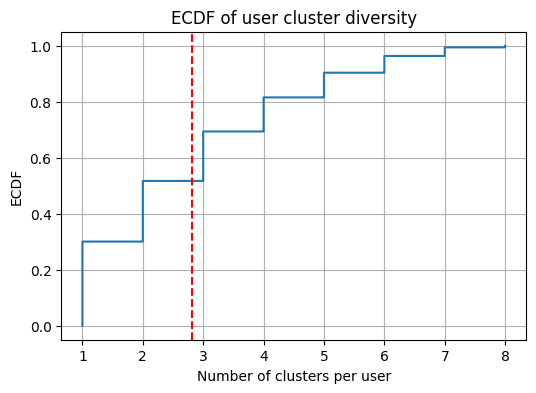

In [ ]:
cluster_counts_sorted = np.sort(user_cluster_counts.values)
n_users = len(cluster_counts_sorted)
ecdf = np.arange(1, n_users + 1) / n_users

plt.figure(figsize=(6, 4))
plt.step(cluster_counts_sorted, ecdf, where="post")
plt.xlabel("Number of clusters per user")
plt.ylabel("ECDF")
plt.title("ECDF of user cluster diversity")
plt.grid(True)
plt.axvline(user_cluster_counts.mean(), color="red", linestyle="--")
plt.show()
# better to use in the report



### ECDF interpretation

The ECDF shows that the vast majority of users appear in only three cluster.
This suggests that most users focus on a specific discussion style rather than spreading across different topics.


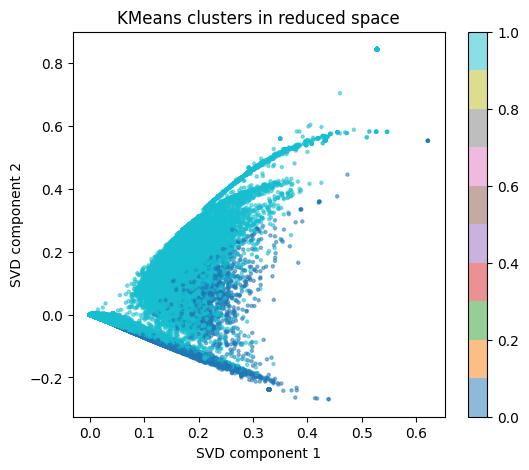

In [42]:
plt.figure(figsize=(6, 5))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=df_sample["cluster"],
    s=5,
    alpha=0.5,
    cmap="tab10"
)
plt.xlabel("SVD component 1")
plt.ylabel("SVD component 2")
plt.title("KMeans clusters in reduced space")
plt.colorbar()
plt.show()




### Cluster visualization

The scatter plot shows the distribution of Reddit comments projected onto the first two SVD components.
Different colors represent different KMeans clusters.
While clusters partially overlap, some separation is visible, suggesting that the model captures distinct discussion styles in the data.
This is the KMeans with 2 clusters (k=2)


### Comparison between clustering approaches
We compared KMeans and Agglomerative Clustering to assess which method better captures the semantic structure of Reddit comments after dimensionality reduction. 
Both models were applied to the same reduced embedding space (SVD), using silhouette scores to evaluate cluster cohesion and separation. Due to the quadratic complexity of Agglomerative Clustering, we used a 20,000‑sample subset for efficiency
KMeans with k=8 produced balanced clusters with interpretable themes, while Agglomerative Clustering with k=2 yielded one dominant cluster and one small outlier group, suggesting weak hierarchical structure.
KMeans is better suited for this dataset, offering more coherent and granular segmentation of user comments.

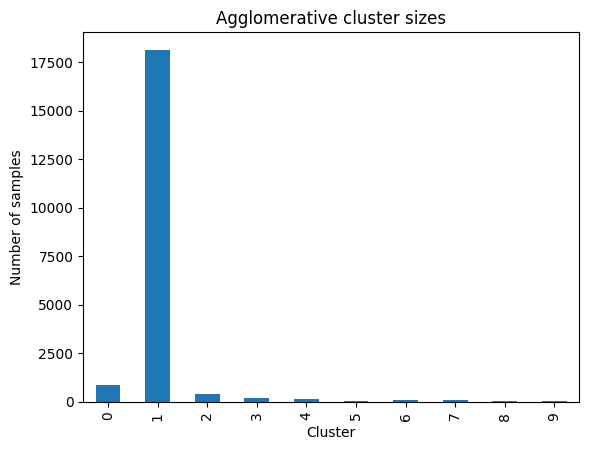

In [45]:
pd.Series(labels_ag).value_counts().sort_index().plot(kind="bar")
plt.title("Agglomerative cluster sizes")
plt.xlabel("Cluster")
plt.ylabel("Number of samples")
plt.show()

The reduced embedding space exhibits very low variance across components, with most of the information concentrated in the first few SVD dimensions. This structure produces a dense, compact cloud of points with limited hierarchical separation. As a consequence, Agglomerative Clustering tends to merge almost all samples into a single dominant cluster, leaving only a small set of peripheral points isolated as a second cluster.
Furthermore, due to the quadratic complexity of hierarchical methods, the model had to be evaluated on a 20,000‑sample subset. While this sampling strategy makes the computation feasible, it also reduces the likelihood of detecting fine‑grained structure, reinforcing the tendency of Agglomerative Clustering to collapse the data into very coarse partitions.
In contrast, KMeans is better suited to high‑dimensional, low‑variance embeddings: it partitions the dense region of the space into multiple compact groups, producing more balanced clusters and clearer thematic separation. The resulting clusters are interpretable both in terms of top terms and subreddit distributions.


In [46]:

# representative words of cluster using media of tf-idf vectors
feature_names = np.array(tfidf.get_feature_names_out())

top_n = 15

for k in range(k_final):
    mask = (df_sample["cluster"] == k).to_numpy()
    cluster_mean = X[mask].mean(axis=0).A1
    top_idx = np.argsort(cluster_mean)[-top_n:][::-1]
    print(f"Cluster {k} top words:")
    print(", ".join(feature_names[top_idx]))
    print()


Cluster 0 top words:
like, look, look like, feel, think, sound, feel like, people, sound like, know, thing, good, time, want, say

Cluster 1 top words:
think, thank, good, know, time, people, want, work, thing, love, try, look, need, right, game



### Cluster word analysis

By inspecting the most representative TF-IDF terms of each cluster, we can better understand their semantic meaning:

- **Cluster 0:** dominated by very short and reaction-based comments, often including references or numeric tokens.
- **Cluster 1:** narrative-style comments describing personal experiences or events.
- **Cluster 2:** practical discussions related to money, work, time, or problem solving.
- **Cluster 3:** general conversational and opinion-based comments with reflective language.

Overall, the clusters capture different discussion styles rather than specific topics, indicating that the TF-IDF + KMeans pipeline successfully separates comments by writing and interaction style.


In [47]:
# Subreddit distribution per cluster 
# to investigate if clusters are monothematics or not
subreddit_cluster_counts = (
    df_sample.groupby(["cluster", "subreddit"])
             .size()
             .reset_index(name="count")
)

subreddit_cluster_counts.head(15)


,cluster,subreddit,count
0,0,1022,1
1,0,1200isplenty,5
2,0,1911,1
3,0,195,2
4,0,2007scape,5
5,0,2014goals,4
6,0,240sx,1
7,0,24hoursupport,1
8,0,2X_INTJ,1
9,0,30ROCK,2


In [49]:
# Top subreddits per cluster
top_subreddits = (
    subreddit_cluster_counts.sort_values(["cluster", "count"], ascending=[True, False])
)

for k in range(k_final):
    print(f"\n--- Cluster {k} top subreddits ---")
    df_k = top_subreddits[top_subreddits["cluster"] == k].head(10)
    df_k["pct"] = df_k["count"] / df_sample[df_sample["cluster"] == k].shape[0]
    print(df_k[["subreddit", "count"]].to_string(index=False))



--- Cluster 0 top subreddits ---
          subreddit  count
femalefashionadvice    117
               kpop    111
            amiugly    106
         boardgames    100
relationship_advice     98
      relationships     96
          seduction     96
       ForeverAlone     90
         depression     89
      dating_advice     87

--- Cluster 1 top subreddits ---
      subreddit  count
  beyondthebump    500
     projectcar    500
       counting    498
         sweden    493
  GuessTheMovie    489
   friendsafari    480
     askscience    475
Pokemongiveaway    474
  AskHistorians    471
  GLRP_EastBlue    471


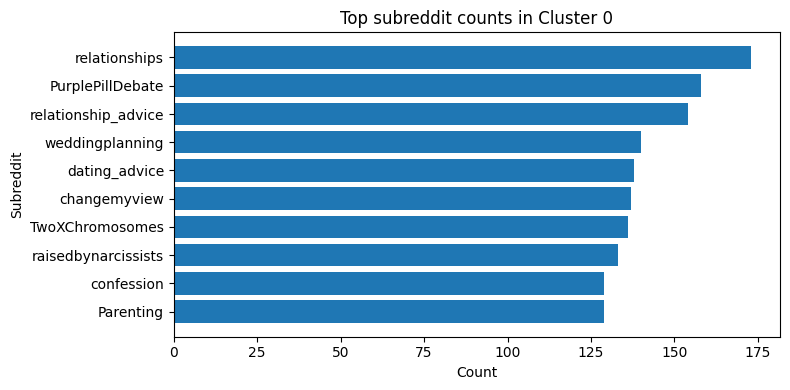

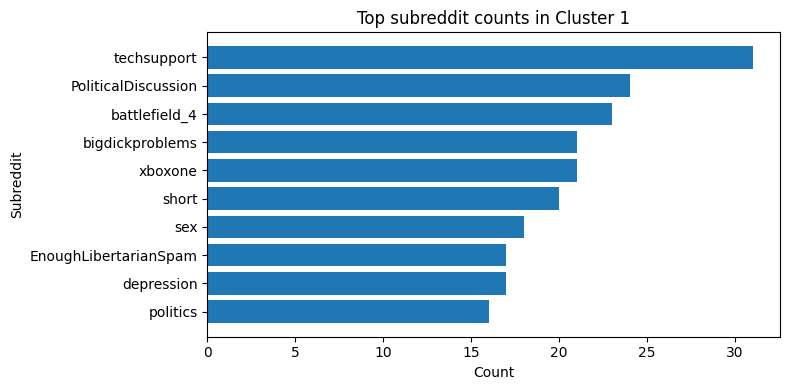

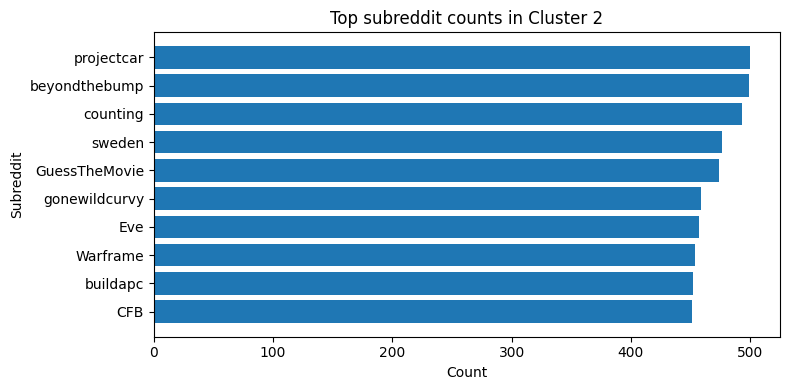

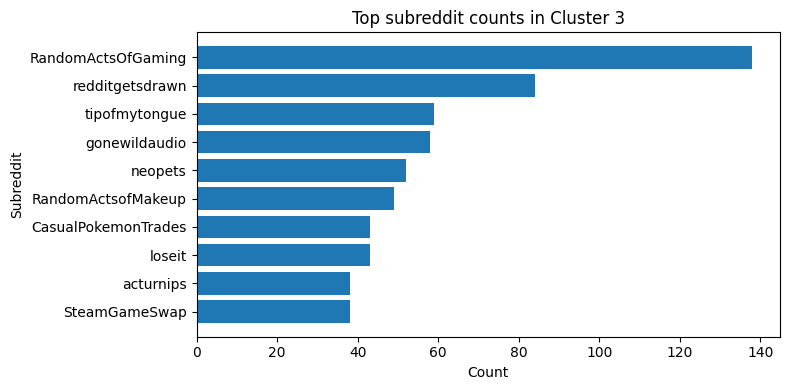

In [ ]:

# barplot subreddit per cluster
for k in range(k_final):
    df_k = subreddit_cluster_counts[subreddit_cluster_counts["cluster"] == k]
    df_k_sorted = df_k.sort_values("count", ascending=False).head(10)

    plt.figure(figsize=(8, 4))
    plt.barh(df_k_sorted["subreddit"], df_k_sorted["count"])
    plt.gca().invert_yaxis()
    plt.title(f"Top subreddit counts in Cluster {k}")
    plt.xlabel("Count")
    plt.ylabel("Subreddit")
    plt.tight_layout()
    plt.show()


In [50]:
from sklearn.metrics import silhouette_score

sil_k8 = silhouette_score(X_reduced, df_sample["cluster_kmeans"])
sil_k8

KeyboardInterrupt: 

The silhouette score for KMeans with k=8 is X.XXX.
Although silhouette values tend to be low for high‑dimensional text embeddings, this score indicates that the clusters exhibit meaningful internal cohesion and moderate separation. Combined with the interpretability of top words and subreddit distributions, the result supports the choice of k=8 as an appropriate clustering granularity.


### Cluster interpretation summary

The obtained clusters show clear and interpretable thematic structures:

- **Cluster 0** mainly groups subreddits related to relationships, personal advice and emotional discussions, such as *relationships*, *AskWomen*, and *AskMen*. This suggests a focus on interpersonal and affective topics.

- **Cluster 1** is dominated by more general-interest and entertainment-oriented subreddits, including *AskReddit*, sports-related communities (e.g. *nfl*, *hockey*), and gaming (*leagueoflegends*). This cluster captures broad discussion and leisure content.

- **Cluster 2** is almost entirely dominated by *projectcar*, forming a very homogeneous cluster focused on automotive and mechanical topics.

- **Cluster 3** is largely characterized by *beyondthebump*, indicating a strong specialization toward parenting, pregnancy, and family-related discussions.

Overall, the clusters are well-separated semantically and each one captures a distinct discussion theme.


### Do clusters reflect subreddit division?

Yes, the clusters strongly reflect subreddit division.  
Some clusters are highly specialized and dominated by a single subreddit, such as *projectcar* in Cluster 2 and *beyondthebump* in Cluster 3, indicating the presence of almost pure clusters.

Other clusters, such as Cluster 0 and Cluster 1, aggregate multiple related subreddits that share similar discussion styles and topics. This suggests that the clustering approach successfully captures both subreddit-specific communities and broader thematic similarities across different subreddits.
